## Load Dataset

In [8]:
import os
import pandas as pd
from scipy.stats import zscore
import matplotlib as matplotlib
from matplotlib import pyplot as plt
import seaborn as sns

In [9]:
df = pd.read_csv("data\Occupancy.csv")
df.head().T

,0,1,2,3,4
date,2015-02-02 14:19:00,2015-02-02 14:19:59,2015-02-02 14:21:00,2015-02-02 14:22:00,2015-02-02 14:23:00
Temperature,23.7,23.718,23.73,23.7225,23.754
Humidity,26.272,26.29,26.23,26.125,26.2
Light,585.2,578.4,572.666667,493.75,488.6
CO2,749.2,760.4,769.666667,774.75,779.0
HumidityRatio,0.004764,0.004773,0.004765,0.004744,0.004767
Occupancy,1,1,1,1,1


# Check columns in dataset

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20560 entries, 0 to 20559
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   date           20560 non-null  object 
 1   Temperature    20560 non-null  float64
 2   Humidity       20560 non-null  float64
 3   Light          20560 non-null  float64
 4   CO2            20560 non-null  float64
 5   HumidityRatio  20560 non-null  float64
 6   Occupancy      20560 non-null  int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 1.1+ MB


In [11]:
df.shape

(20560, 7)

# Check for missing values

In [12]:
df.isnull().sum()

date             0
Temperature      0
Humidity         0
Light            0
CO2              0
HumidityRatio    0
Occupancy        0
dtype: int64

# Look at basic statistics

In [13]:
df.describe()

,Temperature,Humidity,Light,CO2,HumidityRatio,Occupancy
count,20560.000000,20560.000000,20560.000000,20560.000000,20560.000000,20560.000000
mean,20.906212,27.655925,130.756622,690.553276,0.004228,0.231031
std,1.055315,4.982154,210.430875,311.201281,0.000768,0.421503
min,19.000000,16.745000,0.000000,412.750000,0.002674,0.000000
25%,20.200000,24.500000,0.000000,460.000000,0.003719,0.000000
50%,20.700000,27.290000,0.000000,565.416667,0.004292,0.000000
75%,21.525000,31.290000,301.000000,804.666667,0.004832,0.000000
max,24.408333,39.500000,1697.250000,2076.500000,0.006476,1.000000


# Cleaning the dataset

### Check for duplicates

In [14]:
df['date'].duplicated().sum()

np.int64(0)

### Check outliers

In [15]:
numeric_cols = df.select_dtypes(include=['float64']).columns
numeric_cols

Index(['Temperature', 'Humidity', 'Light', 'CO2', 'HumidityRatio'], dtype='object')

In [16]:
from scipy.stats import zscore

# Select only float-type columns (continuous numeric data)
numeric_cols = df.select_dtypes(include=['float32', 'float64']).columns

# Lists to collect outliers as DataFrames for each method
iqr_outliers_all = []
zscore_outliers_all = []

for col in numeric_cols:
    print(f"\nColumn: {col}")

    # IQR Method
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    iqr_outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)]
    print(f"  🔹 IQR outliers: {len(iqr_outliers)}")
    if not iqr_outliers.empty:
        temp = iqr_outliers[[col]].copy()
        temp["column"] = col
        temp["method"] = "IQR"
        iqr_outliers_all.append(temp)

    # Z-Score Method
    valid = df[col].dropna()
    zscores = zscore(valid)
    zscore_outliers = df.loc[valid.index[abs(zscores) > 3]]
    print(f"  🔸 Z-Score outliers (>3): {len(zscore_outliers)}")
    if not zscore_outliers.empty:
        temp = zscore_outliers[[col]].copy()
        temp["column"] = col
        temp["method"] = "Z-Score"
        zscore_outliers_all.append(temp)

# Combine all outliers into unified DataFrames
df_iqr_outliers = pd.concat(iqr_outliers_all, ignore_index=True) if iqr_outliers_all else pd.DataFrame()
df_zscore_outliers = pd.concat(zscore_outliers_all, ignore_index=True) if zscore_outliers_all else pd.DataFrame()


Column: Temperature
  🔹 IQR outliers: 519
  🔸 Z-Score outliers (>3): 143

Column: Humidity
  🔹 IQR outliers: 0
  🔸 Z-Score outliers (>3): 0

Column: Light
  🔹 IQR outliers: 183
  🔸 Z-Score outliers (>3): 162

Column: CO2
  🔹 IQR outliers: 1449
  🔸 Z-Score outliers (>3): 271

Column: HumidityRatio
  🔹 IQR outliers: 0
  🔸 Z-Score outliers (>3): 0


In [17]:
print(f"Columns with IQR outliers: {df_iqr_outliers.column.unique()}")
print(f"Columns with zscore outliers: {df_zscore_outliers.column.unique()}")

Columns with IQR outliers: ['Temperature' 'Light' 'CO2']
Columns with zscore outliers: ['Temperature' 'Light' 'CO2']


In [18]:
iqr_outlier_columns = list(df_iqr_outliers["column"].unique())
zscore_outlier_columns = list(df_zscore_outliers["column"].unique())

# Columns common to both methods
outlier_columns = list(set(iqr_outlier_columns) & set(zscore_outlier_columns))
outlier_columns

['Temperature', 'Light', 'CO2']


Plotting data for: Temperature


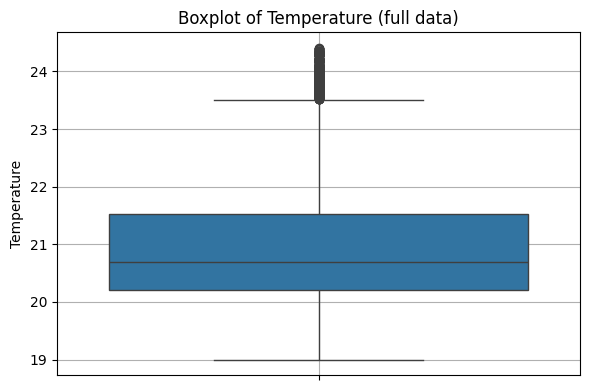

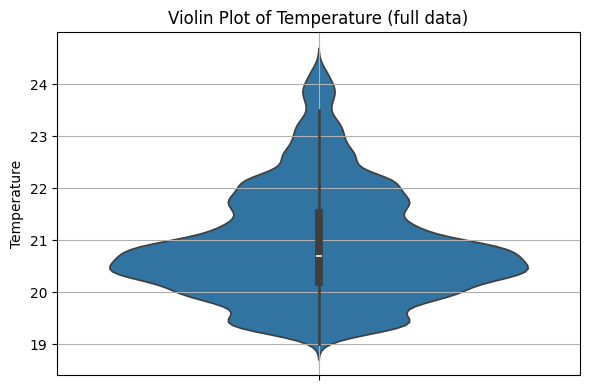


Plotting data for: Light


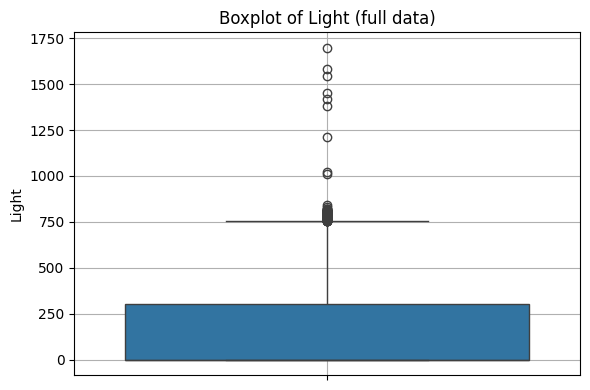

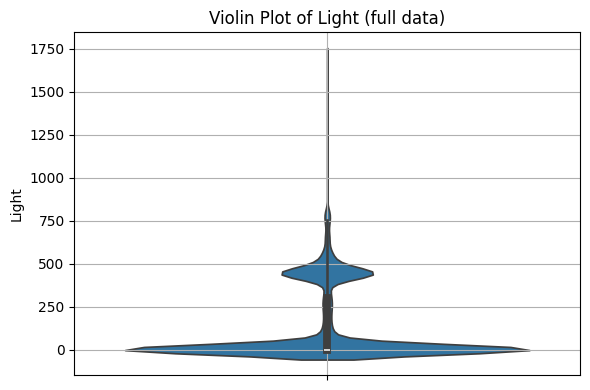


Plotting data for: CO2


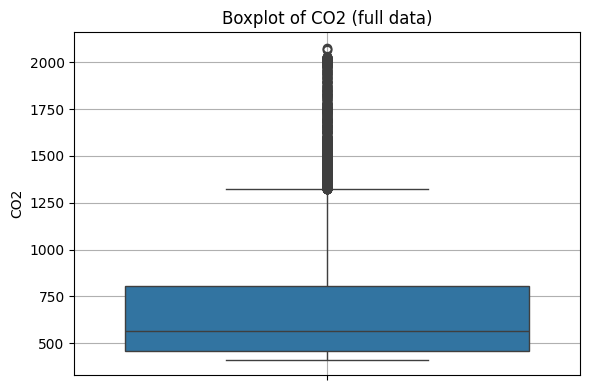

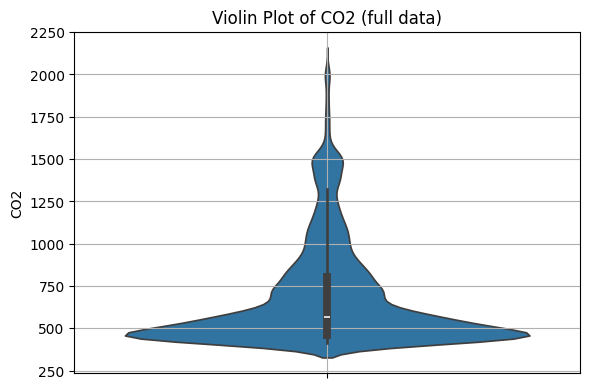

In [19]:
for col in outlier_columns:
    print(f"\nPlotting data for: {col}")

    # --- Boxplot ---
    plt.figure(figsize=(6, 4))
    sns.boxplot(data=df, y=col)
    plt.title(f'Boxplot of {col} (full data)')
    plt.ylabel(col)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # --- Violin Plot ---
    plt.figure(figsize=(6, 4))
    sns.violinplot(data=df, y=col)
    plt.title(f'Violin Plot of {col} (full data)')
    plt.ylabel(col)
    plt.grid(True)
    plt.tight_layout()
    plt.show()
